In [1]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import database_credentials as dc

In [2]:
# Database credentials
postgres_user = dc.user()
postgres_pw = dc.pw()
postgres_host = dc.host()
postgres_port = dc.port()
postgres_db = dc.db()

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

# no need for an open connection,
# as we're only doing a single query
engine.dispose()

In [3]:
# creating a table for order activity
sql = '''
select id, date(created_at), verb, driver_id, order_id, "text"
from ctms_db_public.activities_orderactivity
WHERE date(created_at) >= date(current_date - interval '28 days')
AND date(created_at) < date(current_date)
AND verb IN ('assigned', 'pickedup', 'delivered', 'BOL_emailed')
'''
order_activity = pd.read_sql_query(sql, con=engine)
order_activity = order_activity.rename(columns={'id': 'activity_id', 'date': 'created_at'})
order_activity

,activity_id,created_at,verb,driver_id,order_id,text
0,48087999,2020-12-22,delivered,39112.0,7805163,Michael Strauss marked the order as delivered ...
1,48090463,2020-12-22,BOL_emailed,82086.0,7728236,BOL was emailed to apexmotorsinc@gmail.com
2,48091695,2020-12-22,pickedup,49322.0,7832963,Dmytro Geleban marked the order as picked up f...
3,48094159,2020-12-22,pickedup,9609.0,7821581,Mike marked the order as picked up from origin
4,48095391,2020-12-22,BOL_emailed,67846.0,7832848,BOL was emailed to MasterAutoT@gmail.com
...,...,...,...,...,...,...
633247,49205397,2021-01-18,delivered,77895.0,8016704,Matthew Condouris marked the order as delivere...
633248,49205413,2021-01-18,assigned,55461.0,8025396,"Assigned to DA Hodge, Doug"
633249,49205429,2021-01-18,pickedup,39660.0,8018364,Ruslan Alekperov marked the order as picked up...
633250,49205445,2021-01-18,assigned,84607.0,7995136,Assigned to Carl Galloway


In [4]:
order_activity.isna().sum()/order_activity.isna().count()

activity_id    0.000000
created_at     0.000000
verb           0.000000
driver_id      0.017911
order_id       0.000000
text           0.000000
dtype: float64

In [5]:
# dropping the few driver_id values
order_activity.dropna(inplace=True)

In [6]:
# value counts of order activities
order_activity['verb'].value_counts()

assigned       211464
pickedup       152177
delivered      150170
BOL_emailed    108099
Name: verb, dtype: int64

In [7]:
# creating a table of drivers to get driver guid
sql = '''
SELECT genericuser_ptr_id, carrier_id, guid
FROM ctms_db_public.msd_driver
WHERE is_suspended = False
'''
drivers = pd.read_sql_query(sql, con=engine)
drivers = drivers.rename(columns={'guid': 'driver_guid', 'genericuser_ptr_id': 'driver_id'})
drivers.head()

,driver_id,carrier_id,driver_guid
0,38,20,c03bbd2c-bcf4-43bc-ac35-1a622cdf34f4
1,84,28,5e0349d6-6720-467b-b72d-f248e1be6c4d
2,101,42,bb8229f1-0cb5-46ac-8db8-05ebdb1561f0
3,117,5478,81fe5f04-ff57-4f09-b99b-86b4fab06347
4,136,5478,f65c4afc-6d34-4d74-9a0f-e7323ab305df


In [8]:
# joining driver_guid to order activity table

order_activity = order_activity.merge(drivers, how='inner', left_on='driver_id', right_on='driver_id')
order_activity

,activity_id,created_at,verb,driver_id,order_id,text,carrier_id,driver_guid
0,48087999,2020-12-22,delivered,39112.0,7805163,Michael Strauss marked the order as delivered ...,166,e70448f4-08fd-40fb-9be4-b057a6178dca
1,48087975,2020-12-22,BOL_emailed,39112.0,7803988,BOL was emailed to jelvins@sisbarro.com,166,e70448f4-08fd-40fb-9be4-b057a6178dca
2,48194581,2020-12-23,delivered,39112.0,7828004,Michael Strauss marked the order as delivered ...,166,e70448f4-08fd-40fb-9be4-b057a6178dca
3,48217615,2020-12-24,delivered,39112.0,7840258,Michael Strauss marked the order as delivered ...,166,e70448f4-08fd-40fb-9be4-b057a6178dca
4,48107325,2020-12-22,pickedup,39112.0,7830320,Michael Strauss marked the order as picked up ...,166,e70448f4-08fd-40fb-9be4-b057a6178dca
...,...,...,...,...,...,...,...,...
611220,49204330,2021-01-18,assigned,63243.0,8025138,Assigned to Marcia Brinkman,32349,fe529d0e-e51e-456f-b899-915c74281336
611221,49204724,2021-01-18,assigned,85753.0,8025294,Assigned to Lasha Dispatch,44514,9b3c1992-72df-4aee-b873-d60a44947ba7
611222,49205146,2021-01-18,assigned,71311.0,8019176,Assigned to Dylan Nickerson,39279,2a0e5ab6-d89a-43b7-9c8b-9439103ffbd2
611223,49205486,2021-01-18,assigned,39745.0,8025401,Assigned to Tangela Williams,26214,d83830de-d702-49a7-a8c2-e142622b1afc


In [9]:
result = order_activity.groupby(['driver_id', 'driver_guid']).nunique()[['created_at']]
result.reset_index(inplace=True)
result = result.rename(columns={'created_at': 'unique_days_of_activity'})

In [10]:
result

,driver_id,driver_guid,unique_days_of_activity
0,145.0,a705dfef-bd67-45d4-91cd-648673fade63,11
1,154.0,e482e9b0-8ab7-490c-8fcd-07cfa71e53d9,6
2,174.0,27abbc41-fa85-46c9-9545-418a2fd2d05a,8
3,175.0,95b49d52-c6bb-4ff1-afb0-ab58b9708970,19
4,186.0,c16b55c8-8b3f-4d28-bb96-3fbf4619ab52,24
...,...,...,...
10983,85749.0,e9078383-f20a-469b-8b00-7e7fa6a28d6c,1
10984,85752.0,8da56389-c908-49ec-897c-32e6c193f340,1
10985,85753.0,9b3c1992-72df-4aee-b873-d60a44947ba7,1
10986,85755.0,ced6efe9-5927-48e5-899e-1ad8467a2e85,1


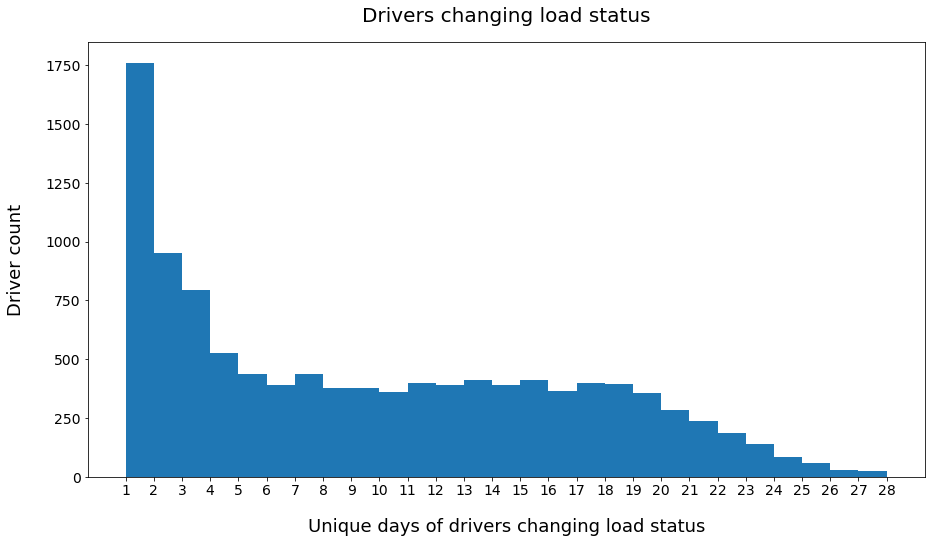

In [11]:
# histogram of unique days of driver activity (changing load status)
plt.figure(figsize=(15,8))
plt.hist(result['unique_days_of_activity'], bins=np.arange(1, 29))
plt.xticks(np.arange(1, 29), fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Unique days of drivers changing load status', fontsize=18, labelpad=20)
plt.ylabel('Driver count', fontsize=18, labelpad=20)
plt.title('Drivers changing load status', fontsize=20, pad=20)
plt.show()

# now let's segment paid and free users

In [12]:
# creating a table for braintree subscriptions
sql = '''
DROP TABLE IF EXISTS #carrier_with_latest_sub_date
;
SELECT 
carrier_id
,max(created_at) AS last_sub
INTO #carrier_with_latest_sub_date
FROM ctms_db_public.billing_braintreesubscription
WHERE braintree_subscription_status IN ('Active', 'Past Due', 'Pending')
GROUP BY carrier_id
;
SELECT 
#carrier_with_latest_sub_date.carrier_id
,last_sub
,braintree_subscription_status
FROM #carrier_with_latest_sub_date
JOIN ctms_db_public.billing_braintreesubscription
ON #carrier_with_latest_sub_date.carrier_id = billing_braintreesubscription.carrier_id
AND #carrier_with_latest_sub_date.last_sub = billing_braintreesubscription.created_at
WHERE billing_braintreesubscription.braintree_subscription_status IN ('Active', 'Past Due', 'Pending')
;
'''
braintree_subs = pd.read_sql_query(sql, con=engine)
braintree_subs

,carrier_id,last_sub,braintree_subscription_status
0,2978,2016-11-26 09:21:34.937541,Active
1,5164,2017-01-05 22:15:51.921429,Active
2,3109,2016-11-26 09:21:33.283626,Active
3,8280,2017-06-17 15:20:29.527819,Active
4,831,2016-11-26 09:21:32.012823,Active
...,...,...,...
2866,26442,2021-01-18 18:44:02.175590,Active
2867,40915,2021-01-18 20:07:54.276443,Active
2868,7241,2021-01-18 20:40:43.572320,Active
2869,41228,2021-01-18 21:40:39.026505,Active


In [13]:
# creating a carriers table
sql = '''
SELECT name, id, guid
FROM ctms_db_public.msd_carrier
WHERE test_account = False
'''
carriers = pd.read_sql_query(sql, con=engine)
carriers = carriers.rename(columns={'id': 'carrier_id', 'guid': 'carrier_guid'})
carriers

,name,carrier_id,carrier_guid
0,ayman,7,71918a40-f1df-4b52-b925-129ed39183f1
1,CN2,16,c623837b-04ee-4cf7-a44c-bca993c4d057
2,Transcontinental Express LLC,25,e835ef60-4200-4863-916a-0eed5bd18f93
3,Sifuentes Auto Transport,29,0a142cbc-cc41-42be-96cc-9bee4dde0929
4,A1 USA Express,37,e97661bf-33fa-4b77-b4b4-23c960e54da8
...,...,...,...
40891,FINISH LINE RACING TRANSPORT LLC,43695,3e63fc3b-a64d-4a82-91bb-3e0dd230b34b
40892,Rainier Trucking LLC.,14050,d96272b4-3f12-4e9f-8fc3-bc9e92848331
40893,ROLLIN ENTERPRISES INCORPORATED,29525,b552be0b-fba4-4771-9e90-48cbabcf44eb
40894,UZ Auto Trans Inc,166,3da07a51-afb4-4efe-8be0-29a823c2fc8f


In [14]:
# joining carriers with braintree table

braintree_with_carriers = braintree_subs.merge(carriers, left_on='carrier_id', right_on='carrier_id')
braintree_with_carriers

,carrier_id,last_sub,braintree_subscription_status,name,carrier_guid
0,2978,2016-11-26 09:21:34.937541,Active,AU-THENTIC INDUSTRIES LLC,1e1366e5-0c67-4019-bd33-e255416c7df7
1,5164,2017-01-05 22:15:51.921429,Active,Capital Trucking LLC,255749b3-8b17-421a-a3ed-353ca3472495
2,3109,2016-11-26 09:21:33.283626,Active,MEI Transportation Services Inc,49cdf08d-56ea-48c6-87d1-91515bf31639
3,8280,2017-06-17 15:20:29.527819,Active,ZPA Incorporated,ba962dbd-1e32-4caf-83e9-59db46983d6a
4,831,2016-11-26 09:21:32.012823,Active,Born Again Hauling,6f3b99e9-ad63-4ca1-abae-44b6c7cd0a14
...,...,...,...,...,...
2866,26442,2021-01-18 18:44:02.175590,Active,TRINITY DRIVE-AWAY LLC,782d3b6f-6ce2-47e2-984b-9eefb50096c9
2867,40915,2021-01-18 20:07:54.276443,Active,2517 INC,2d596f76-0137-4a06-b14b-556bad55f2e4
2868,7241,2021-01-18 20:40:43.572320,Active,DBN Trans Inc.,b81b0e8c-b9ec-4d73-85b8-ea3d10d7e962
2869,41228,2021-01-18 21:40:39.026505,Active,UNIQUE TOWING & RECOVERY,e7f98c54-f6d2-40dc-9d48-d0710a80869e


# Paid users

In [15]:
paid_user_order_activity = order_activity.merge(braintree_with_carriers, left_on='carrier_id', right_on='carrier_id')
paid_user_order_activity

,activity_id,created_at,verb,driver_id,order_id,text,carrier_id,driver_guid,last_sub,braintree_subscription_status,name,carrier_guid
0,48087999,2020-12-22,delivered,39112.0,7805163,Michael Strauss marked the order as delivered ...,166,e70448f4-08fd-40fb-9be4-b057a6178dca,2016-11-26 09:21:31.064359,Active,UZ Auto Trans Inc,3da07a51-afb4-4efe-8be0-29a823c2fc8f
1,48087975,2020-12-22,BOL_emailed,39112.0,7803988,BOL was emailed to jelvins@sisbarro.com,166,e70448f4-08fd-40fb-9be4-b057a6178dca,2016-11-26 09:21:31.064359,Active,UZ Auto Trans Inc,3da07a51-afb4-4efe-8be0-29a823c2fc8f
2,48194581,2020-12-23,delivered,39112.0,7828004,Michael Strauss marked the order as delivered ...,166,e70448f4-08fd-40fb-9be4-b057a6178dca,2016-11-26 09:21:31.064359,Active,UZ Auto Trans Inc,3da07a51-afb4-4efe-8be0-29a823c2fc8f
3,48217615,2020-12-24,delivered,39112.0,7840258,Michael Strauss marked the order as delivered ...,166,e70448f4-08fd-40fb-9be4-b057a6178dca,2016-11-26 09:21:31.064359,Active,UZ Auto Trans Inc,3da07a51-afb4-4efe-8be0-29a823c2fc8f
4,48107325,2020-12-22,pickedup,39112.0,7830320,Michael Strauss marked the order as picked up ...,166,e70448f4-08fd-40fb-9be4-b057a6178dca,2016-11-26 09:21:31.064359,Active,UZ Auto Trans Inc,3da07a51-afb4-4efe-8be0-29a823c2fc8f
...,...,...,...,...,...,...,...,...,...,...,...,...
402183,49159548,2021-01-18,assigned,49064.0,8016888,Assigned to Slav Babinov,21640,584eacae-3ddd-4430-914c-26583c4679f4,2020-11-24 01:51:32.001093,Active,ROYAL MOTOR LINES INC,a5df8342-1981-4d20-8c8f-474494519615
402184,49166625,2021-01-18,assigned,49064.0,8012620,Assigned to Slav Babinov,21640,584eacae-3ddd-4430-914c-26583c4679f4,2020-11-24 01:51:32.001093,Active,ROYAL MOTOR LINES INC,a5df8342-1981-4d20-8c8f-474494519615
402185,49166705,2021-01-18,pickedup,49064.0,8012620,Slav Babinov marked the order as picked up fro...,21640,584eacae-3ddd-4430-914c-26583c4679f4,2020-11-24 01:51:32.001093,Active,ROYAL MOTOR LINES INC,a5df8342-1981-4d20-8c8f-474494519615
402186,49194900,2021-01-18,assigned,29403.0,8023638,Assigned to Will Brown-Mike & Son Towing LLC(d...,20749,d4fd0c15-bed1-44dc-81cb-e7d82af4693a,2018-12-13 17:29:33.583166,Active,Mike & Son Towing LLC,11e1cca2-79d9-4966-a079-6684bd8a521c


In [16]:
result_paid_users = paid_user_order_activity.groupby(['driver_id', 'driver_guid']).nunique()[['created_at']]
result_paid_users.reset_index(inplace=True)
result_paid_users = result_paid_users.rename(columns={'created_at': 'unique_days_of_activity'})
result_paid_users

,driver_id,driver_guid,unique_days_of_activity
0,145.0,a705dfef-bd67-45d4-91cd-648673fade63,11
1,260.0,3f0a1f39-6719-45f4-87f5-59fe4c7d186f,22
2,267.0,47f61b55-dfc4-4f22-b140-01f3c1dd27bf,13
3,428.0,c5bf4b94-0b5a-4d6c-a6be-603ee1f215a4,16
4,634.0,787b5d1f-2f7e-438c-89d2-d3c3e90d6e06,8
...,...,...,...
5325,85723.0,4db256b9-9075-40bf-af8f-869c9a258365,1
5326,85729.0,1e503dc6-01cc-41fb-9e6b-bfd74f23edce,1
5327,85731.0,806888e1-121e-4dc5-8cef-2c517a7b741a,1
5328,85747.0,42327ad6-8444-4435-bfff-c0d7f0fe7148,1


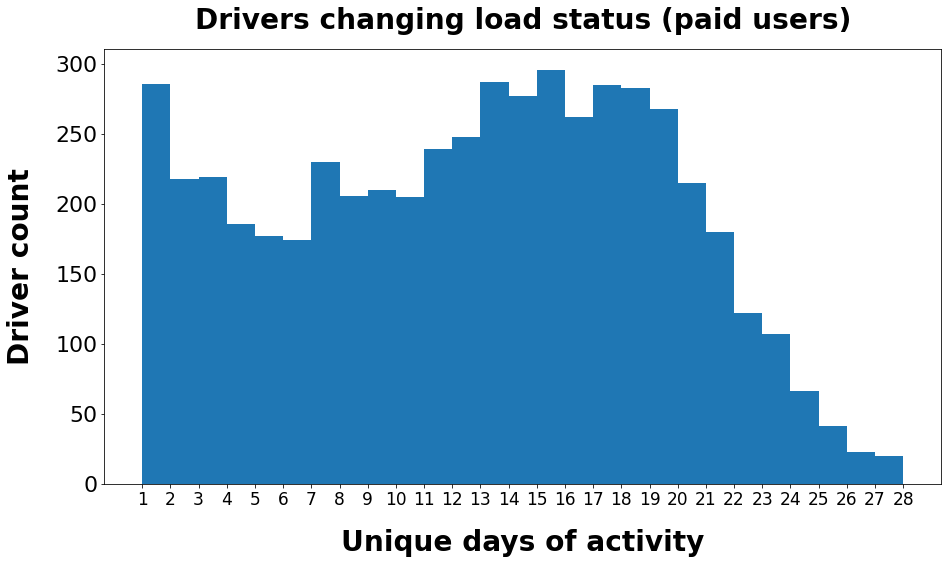

In [17]:
# histogram of unique days of driver activity (changing load status)
plt.figure(figsize=(15,8))
plt.hist(result_paid_users['unique_days_of_activity'], bins=np.arange(1, 29))
plt.xticks(np.arange(1, 29), fontsize=17)
plt.yticks(fontsize=22)
plt.xlabel('Unique days of activity', fontsize=28, fontweight='bold', labelpad=20)
plt.ylabel('Driver count', fontsize=28, fontweight='bold', labelpad=20)
plt.title('Drivers changing load status (paid users)', fontsize=28, fontweight='bold', pad=20)
plt.show()

# Free users

In [18]:
free_user_order_activity = order_activity.merge(braintree_with_carriers, how='left',
                                                left_on='carrier_id', right_on='carrier_id')

# Free users
non_payers = free_user_order_activity['braintree_subscription_status'].isna() == True
# Dropping all paid users
free_user_order_activity = free_user_order_activity[non_payers]
free_user_order_activity

,activity_id,created_at,verb,driver_id,order_id,text,carrier_id,driver_guid,last_sub,braintree_subscription_status,name,carrier_guid
62,48090463,2020-12-22,BOL_emailed,82086.0,7728236,BOL was emailed to apexmotorsinc@gmail.com,35784,186b0651-39f1-4b19-9cd6-5bf04ca73d2b,NaT,NaN,NaN,NaN
63,48090461,2020-12-22,delivered,82086.0,7728236,Daniel Kovalenko marked the order as delivered...,35784,186b0651-39f1-4b19-9cd6-5bf04ca73d2b,NaT,NaN,NaN,NaN
64,48624349,2021-01-06,assigned,82086.0,7929657,Assigned to Daniel Kovalenko,35784,186b0651-39f1-4b19-9cd6-5bf04ca73d2b,NaT,NaN,NaN,NaN
65,48091695,2020-12-22,pickedup,49322.0,7832963,Dmytro Geleban marked the order as picked up f...,30995,d87d6c55-2842-45ef-8613-3ff748d5be11,NaT,NaN,NaN,NaN
66,48113496,2020-12-22,delivered,49322.0,7832963,Dmytro Geleban marked the order as delivered t...,30995,d87d6c55-2842-45ef-8613-3ff748d5be11,NaT,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
611220,49204330,2021-01-18,assigned,63243.0,8025138,Assigned to Marcia Brinkman,32349,fe529d0e-e51e-456f-b899-915c74281336,NaT,NaN,NaN,NaN
611221,49204724,2021-01-18,assigned,85753.0,8025294,Assigned to Lasha Dispatch,44514,9b3c1992-72df-4aee-b873-d60a44947ba7,NaT,NaN,NaN,NaN
611222,49205146,2021-01-18,assigned,71311.0,8019176,Assigned to Dylan Nickerson,39279,2a0e5ab6-d89a-43b7-9c8b-9439103ffbd2,NaT,NaN,NaN,NaN
611223,49205486,2021-01-18,assigned,39745.0,8025401,Assigned to Tangela Williams,26214,d83830de-d702-49a7-a8c2-e142622b1afc,NaT,NaN,NaN,NaN


In [19]:
result_free_users = free_user_order_activity.groupby(['driver_id', 'driver_guid']).nunique()[['created_at']]
result_free_users.reset_index(inplace=True)
result_free_users = result_free_users.rename(columns={'created_at': 'unique_days_of_activity'})
result_free_users

,driver_id,driver_guid,unique_days_of_activity
0,154.0,e482e9b0-8ab7-490c-8fcd-07cfa71e53d9,6
1,174.0,27abbc41-fa85-46c9-9545-418a2fd2d05a,8
2,175.0,95b49d52-c6bb-4ff1-afb0-ab58b9708970,19
3,186.0,c16b55c8-8b3f-4d28-bb96-3fbf4619ab52,24
4,213.0,733216f1-6987-4c63-9cb6-14189c9b8b43,7
...,...,...,...
5653,85748.0,a177e775-2bbe-474b-a644-145981d56f89,1
5654,85749.0,e9078383-f20a-469b-8b00-7e7fa6a28d6c,1
5655,85752.0,8da56389-c908-49ec-897c-32e6c193f340,1
5656,85753.0,9b3c1992-72df-4aee-b873-d60a44947ba7,1


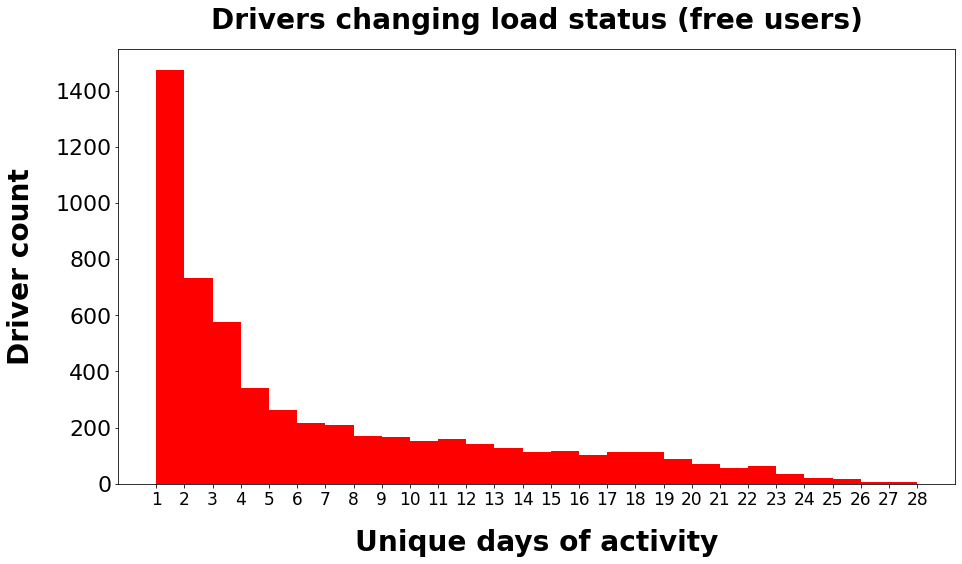

In [20]:
# histogram of unique days of driver activity (changing load status)
plt.figure(figsize=(15,8))
plt.hist(result_free_users['unique_days_of_activity'], bins=np.arange(1, 29), color='red')
plt.xticks(np.arange(1, 29), fontsize=17)
plt.yticks(fontsize=22)
plt.xlabel('Unique days of activity', fontsize=28, fontweight='bold', labelpad=20)
plt.ylabel('Driver count', fontsize=28, fontweight='bold', labelpad=20)
plt.title('Drivers changing load status (free users)', fontsize=28, fontweight='bold', pad=20)
plt.show()

In [21]:
total_paid_drivers_for_days_active = []

for i in range(1,29):
    paid_active_driver_count = (result_paid_users[result_paid_users['unique_days_of_activity'] >= i]
                           .groupby('unique_days_of_activity').count()['driver_guid'].sum())
    
    total_paid_drivers_for_days_active.append(paid_active_driver_count)
    


total_free_drivers_for_days_active = []

for i in range(1,29):
    free_active_driver_count = (result_free_users[result_free_users['unique_days_of_activity'] >= i]
                           .groupby('unique_days_of_activity').count()['driver_guid'].sum())
    
    total_free_drivers_for_days_active.append(free_active_driver_count)

In [22]:
paid_active_drivers = pd.DataFrame()
paid_active_drivers['definition_is_this_many_days_active'] = np.arange(1,29)
paid_active_drivers.set_index('definition_is_this_many_days_active', inplace=True)
paid_active_drivers['total_drivers_at_least_this_active'] = total_paid_drivers_for_days_active
paid_active_drivers['total_percentage_active'] = round(100*paid_active_drivers['total_drivers_at_least_this_active']
                                                       /len(result_paid_users))
paid_active_drivers['total_percentage_dormant'] = 100 - paid_active_drivers['total_percentage_active']


free_active_drivers = pd.DataFrame()
free_active_drivers['definition_is_this_many_days_active'] = np.arange(1,29)
free_active_drivers.set_index('definition_is_this_many_days_active', inplace=True)
free_active_drivers['total_drivers_at_least_this_active'] = total_free_drivers_for_days_active
free_active_drivers['total_percentage_active'] = round(100*free_active_drivers['total_drivers_at_least_this_active']
                                                       /len(result_free_users))
free_active_drivers['total_percentage_dormant'] = 100 - free_active_drivers['total_percentage_active']

In [23]:
def paid_vs_free(paid_metric_definition, free_metric_definition):
    plt.figure(figsize=(13,11))
    plt.subplots_adjust(wspace=.9)
    
    plt.subplot(1,2,1)
    paid_graph = sns.barplot(x=['active', 'dormant'],
                        y=[paid_active_drivers.loc[paid_metric_definition, 'total_drivers_at_least_this_active'],
                           (paid_active_drivers.loc[1, 'total_drivers_at_least_this_active'] - 
                            paid_active_drivers.loc[paid_metric_definition, 'total_drivers_at_least_this_active'])],
                        palette='muted')
    for p in paid_graph.patches:
        paid_graph.annotate(p.get_height(), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, -20), 
                       textcoords = 'offset points',
                       fontsize=20)
        paid_graph.annotate('{}%'.format(round(100*p.get_height()/paid_active_drivers.loc[1, 'total_drivers_at_least_this_active'])), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 15), 
                       textcoords = 'offset points',
                       fontsize=20)
    plt.xticks(fontsize=18, fontweight='bold')
    plt.yticks(fontsize=18)
    plt.ylabel('Driver Count', fontsize=28, fontweight='bold', labelpad=20)
    title = '''If {} out of 28 days
changed status
(paid users)'''.format(paid_metric_definition)
    plt.title(title, fontsize=28, fontweight='bold', pad=20)

        
    
    plt.subplot(1,2,2)
    free_graph = sns.barplot(x=['active', 'dormant'],
                        y=[free_active_drivers.loc[free_metric_definition, 'total_drivers_at_least_this_active'],
                           (free_active_drivers.loc[1, 'total_drivers_at_least_this_active'] - 
                            free_active_drivers.loc[free_metric_definition, 'total_drivers_at_least_this_active'])],
                        palette='muted')
    for p in free_graph.patches:
        free_graph.annotate(p.get_height(), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, -20), 
                       textcoords = 'offset points',
                       fontsize=20)
        free_graph.annotate('{}%'.format(round(100*p.get_height()/free_active_drivers.loc[1, 'total_drivers_at_least_this_active'])), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 15), 
                       textcoords = 'offset points',
                       fontsize=20)
    plt.xticks(fontsize=18, fontweight='bold')
    plt.yticks(fontsize=18)
    title = '''If {} out of 28 days
changed status
(non-paid users)'''.format(free_metric_definition)
    plt.title(title, fontsize=28, fontweight='bold', pad=20)
    plt.show()

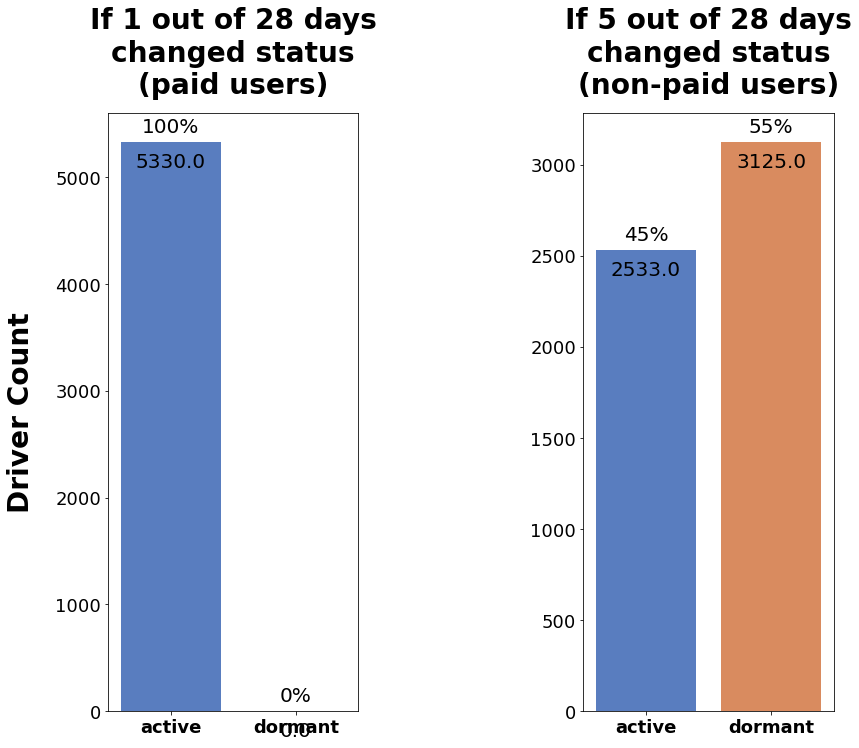

In [24]:
paid_vs_free(1, 5)

In [25]:
braintree_with_carriers = braintree_subs.merge(carriers, left_on='carrier_id', right_on='carrier_id')
braintree_with_carriers
all_paid_drivers = drivers.merge(braintree_with_carriers, left_on='carrier_id', right_on='carrier_id')
all_paid_drivers

,driver_id,carrier_id,driver_guid,last_sub,braintree_subscription_status,name,carrier_guid
0,782,361,385501a9-2116-415c-8698-cc380c6830cb,2020-09-19 01:11:30.442133,Active,Big Boy Transporting & Towing,63d3ff59-538a-4f6a-a123-880f10830dfd
1,781,361,1c1503e2-a908-48f4-a880-ed528efd3b12,2020-09-19 01:11:30.442133,Active,Big Boy Transporting & Towing,63d3ff59-538a-4f6a-a123-880f10830dfd
2,10352,361,e98aca37-2003-4a02-b4f6-76ba9061849b,2020-09-19 01:11:30.442133,Active,Big Boy Transporting & Towing,63d3ff59-538a-4f6a-a123-880f10830dfd
3,4032,361,370aff85-faa5-4a65-a921-08ce62f1bfda,2020-09-19 01:11:30.442133,Active,Big Boy Transporting & Towing,63d3ff59-538a-4f6a-a123-880f10830dfd
4,11663,361,eb3c0740-972a-47b6-a922-048184bbe962,2020-09-19 01:11:30.442133,Active,Big Boy Transporting & Towing,63d3ff59-538a-4f6a-a123-880f10830dfd
...,...,...,...,...,...,...,...
12142,7410,4347,c47914ad-5a86-416b-8f24-e1d413fe02f0,2016-11-26 09:21:34.350835,Active,G & D Trucking of Illinois Inc.,f8bc0c21-3b78-4913-804c-f78f04f3ca46
12143,34017,23172,59badc3d-7f65-49d2-8934-85e5d1f555f3,2018-12-25 18:16:44.657729,Active,STANDARD TOWING & TRANSPORT,f6ebd6f5-ebfa-42f8-9849-1235aef3ee11
12144,42299,27544,a0007ed8-ed8a-40a6-a18f-ca19342a97ae,2019-06-11 17:29:42.565170,Active,PERFECT TIMING TOWING,a0315d89-0730-4a71-8ee9-43e2c568dabc
12145,56652,34459,4044b68d-cf05-497f-998f-71c75cb988eb,2020-01-15 21:06:37.672882,Active,AUTOGREEN INC,09594ef3-e1dc-4f52-87f5-da0515b8dbb3


In [26]:
all_free_drivers = drivers.merge(braintree_with_carriers, how='left', left_on='carrier_id', right_on='carrier_id')
# getting all free users
non_payers = all_free_drivers['braintree_subscription_status'].isna() == True
#dropping all rows with paid users
all_free_drivers = all_free_drivers[non_payers]
all_free_drivers

,driver_id,carrier_id,driver_guid,last_sub,braintree_subscription_status,name,carrier_guid
0,38,20,c03bbd2c-bcf4-43bc-ac35-1a622cdf34f4,NaT,NaN,NaN,NaN
1,84,28,5e0349d6-6720-467b-b72d-f248e1be6c4d,NaT,NaN,NaN,NaN
2,101,42,bb8229f1-0cb5-46ac-8db8-05ebdb1561f0,NaT,NaN,NaN,NaN
3,117,5478,81fe5f04-ff57-4f09-b99b-86b4fab06347,NaT,NaN,NaN,NaN
4,136,5478,f65c4afc-6d34-4d74-9a0f-e7323ab305df,NaT,NaN,NaN,NaN
...,...,...,...,...,...,...,...
62962,80946,38749,3402310c-7fad-42cb-bbc3-0485023c9e51,NaT,NaN,NaN,NaN
62965,84148,335,a2a9bffd-dc33-4411-9d13-f748aaca8a13,NaT,NaN,NaN,NaN
62967,84776,44078,fa2bfa7d-4d78-4c0b-ab54-da4817be1c4e,NaT,NaN,NaN,NaN
62970,85760,33856,eec1309f-341a-4120-b3f3-c83fb1e8c76f,NaT,NaN,NaN,NaN


In [27]:
paid_active_drivers = pd.DataFrame()
paid_active_drivers['definition_is_this_many_days_active'] = np.arange(1,29)
paid_active_drivers.set_index('definition_is_this_many_days_active', inplace=True)
paid_active_drivers['total_drivers_at_least_this_active'] = total_paid_drivers_for_days_active
paid_active_drivers['total_dormant_drivers'] = ([len(all_paid_drivers) - total_paid_drivers_for_days_active[x]
                                                 for x in range(len(total_paid_drivers_for_days_active))])
paid_active_drivers['total_percentage_active'] = round(100*paid_active_drivers['total_drivers_at_least_this_active']
                                                       /len(all_paid_drivers))
paid_active_drivers['total_percentage_dormant'] = 100 - paid_active_drivers['total_percentage_active']

free_active_drivers = pd.DataFrame()
free_active_drivers['definition_is_this_many_days_active'] = np.arange(1,29)
free_active_drivers.set_index('definition_is_this_many_days_active', inplace=True)
free_active_drivers['total_drivers_at_least_this_active'] = total_free_drivers_for_days_active
free_active_drivers['total_dormant_drivers'] = ([len(all_free_drivers) - total_free_drivers_for_days_active[x]
                                                 for x in range(len(total_free_drivers_for_days_active))])
free_active_drivers['total_percentage_active'] = round(100*free_active_drivers['total_drivers_at_least_this_active']
                                                       /len(all_free_drivers))
free_active_drivers['total_percentage_dormant'] = 100 - free_active_drivers['total_percentage_active']

In [28]:
def all_users(paid_metric_definition, free_metric_definition):
    plt.figure(figsize=(13,11))
    plt.subplots_adjust(wspace=.9)
    
    plt.subplot(1,2,1)
    paid_graph = sns.barplot(x=['active', 'dormant'],
                        y=[paid_active_drivers.loc[paid_metric_definition, 'total_drivers_at_least_this_active'],
                           paid_active_drivers.loc[paid_metric_definition, 'total_dormant_drivers']],
                        palette='muted')
    for p in paid_graph.patches:
        paid_graph.annotate(p.get_height(), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, -20), 
                       textcoords = 'offset points',
                       fontsize=20)
        paid_graph.annotate('{}%'.format(round(100*p.get_height()/len(all_paid_drivers))), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 15), 
                       textcoords = 'offset points',
                       fontsize=20)
    plt.xticks(fontsize=18, fontweight='bold')
    plt.yticks(fontsize=18)
    plt.ylabel('Driver Count', fontsize=28, fontweight='bold', labelpad=20)
    title = '''If {} out of 28 days
changed load status
(paid users)'''.format(paid_metric_definition)
    plt.title(title, fontsize=28, fontweight='bold', pad=20)

        
    
    plt.subplot(1,2,2)
    free_graph = sns.barplot(x=['active', 'dormant'],
                        y=[free_active_drivers.loc[free_metric_definition, 'total_drivers_at_least_this_active'], 
                           free_active_drivers.loc[free_metric_definition, 'total_dormant_drivers']],
                        palette='muted')
    for p in free_graph.patches:
        free_graph.annotate(p.get_height(), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, -20), 
                       textcoords = 'offset points',
                       fontsize=20)
        free_graph.annotate('{}%'.format(round(100*p.get_height()/len(all_free_drivers))), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 15), 
                       textcoords = 'offset points',
                       fontsize=20)
    plt.xticks(fontsize=18, fontweight='bold')
    plt.yticks(fontsize=18)
    title = '''If {} out of 28 days
changed load status
(free users)'''.format(free_metric_definition)
    plt.title(title, fontsize=28, fontweight='bold', pad=20)
    plt.show()

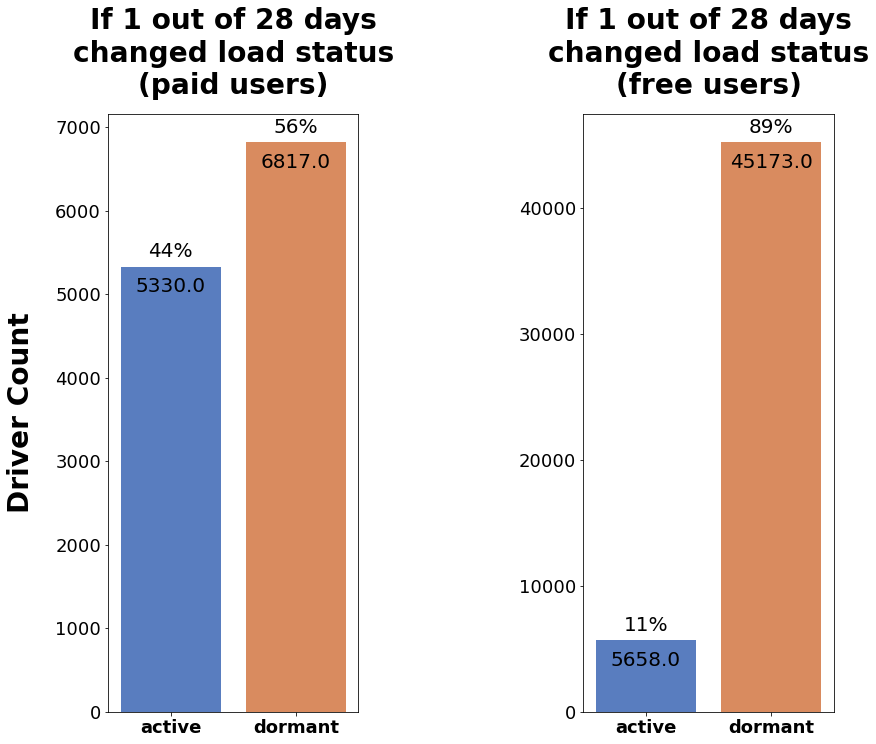

In [29]:
all_users(1,1)